# 02807: Project 1
 



# Introduction to the Datasets

![link text](https://ph-files.imgix.net/069dd825-cddf-4048-adde-8e81396c2c68?auto=format)


You will be working with datasets obtained through the [The Movie Database (TMDb) API](https://developers.themoviedb.org/3/getting-started/introduction). The first dataset is part of the MovieLens Latest Full Dataset, comprising 26 million ratings on 45.000 movies from 27.000 users. Let's look at the features in this dataset.

**Features**

* **adult**: Indicates if the movie is X-Rated.
* **belongs_to_collection**: A stringified dictionary with info on the movie series a particular film belongs to (e.g.: Lord of the Rings).
* **budget**: The movie budget in dollars.
* **genres**: A stringified list of dictionaries describing all genres associated with the movie.
* **homepage**: The movie's official homepage.
* **id**: An identifier for the movie.
* **imdb_id**: IMDB's identifier for the movie.
* **original_language**: The language in which the movie was shot.
* **original_title**: The original title of the movie.
* **overview**: A brief text about the movie.
* **popularity**: A Popularity Score given by TMDb.
* **poster_path**: The URL of the poster image.
* **production_companies**: A stringified list of production companies involved with making of the movie.
* **production_countries**: A stringified list of countries in which the movie was produced.
* **release_date**: Release date of the movie in theaters.
* **revenue**: The total revenue of the movie in dollars.
* **runtime**: The runtime of the movie in minutes.
* **spoken_languages**: A stringified list of languages spoken in the film.
* **status**: The status of the movie (Released, To Be Released, etc.)
* **tagline**: The movie's tagline.
* **title**: The official title of the movie.
* **video**: Indicates whether there is a video of the movie in TMDb.
* **vote_average**: The average rating of the movie, on a 0-10 scale.
* **vote_count**: The number of votes by users, as counted by TMDb.

# Imports

First, let's make sure to import Pandas and NumPy. 

In [2]:
import pandas as pd 
import numpy as np

# Exercise 1: Loading, preprocessing and cleaning the data (15 points)

Read the movie dataset from the following URL.

In [3]:
url = 'http://courses.compute.dtu.dk/02807/2021/projects/project1/movies_metadata.csv'

## Part 1: Reading and preprocessing the data (10 pts)

Pandas infers a data type for raw data from a `.csv`, defaulting to string type when no other `dtype` could be established. For example, the `genres` column in our dataset is read as a string with a *stringified* list of dictionaries as cell content. 

Some preprocessing steps are therefore needed, to convert the columns into their proper data types.

Write a function `load_movies_data()` that reads the URL into a Pandas DataFrame and preprocesses its columns to ensure that:

1. Data in the `release_date` column consists of Pandas `Timestamp` objects, except for missing values. For example, executing a code cell with `df.release_date[0]` should display the output `Timestamp('1995-10-30 00:00:00')`.

2. Data in `belongs_to_collection` consists of dictionaries, except for missing values.

3. Data in `genres`, `production_companies` and `production_countries` consists of lists of dictionaries, except for missing values. 

For example, executing a code cell with `df.genres[0]` should display the output 
```
[{'id': 16, 'name': 'Animation'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 10751, 'name': 'Family'}]
```
which is a list type, not a string. The elements of the list are dictionaries (executing `df.genres[0][0]['name']` returns `'Animation'`). 

**Hint**: for items 2 and 3, you should use `ast.literal_eval`.

These conversions can be performed using Pandas' built-in functions and/or calling Pandas' `apply()` with appropriate arguments. Avoid explicit looping. You'll be asked below to time the loading and preprocessing step. 

In [4]:
# your code goes here
from ast import literal_eval

def load_movies_data(url):
    # date
    parse_dates = ['release_date']
    date_parser = lambda col : pd.to_datetime(col, errors='coerce') 

    # convert
    """ func: convert to dict. """
    def convert_dic(val):
        if val: return literal_eval(val)
        else: return {}  

    """ func: convert to list """
    def convert_lst(val):
        if val: return literal_eval(val)
        else: return []

    """ converters """
    converters = {
        'belongs_to_collection':convert_dic,
        'genres':convert_lst,
        'production_companies':convert_lst, 
        'production_countries':convert_lst,
        }    

    # mix col type 
    dtype = {'popularity' : 'str'}
 
    # return
    return pd.read_csv(
                url, 
                engine = 'c',
                parse_dates = parse_dates,
                date_parser = date_parser,
                converters = converters,
                dtype = dtype,
                )

Now call `load_movies_data()` and load the data into a DataFrame `df`.

In [5]:
# your code goes here
df = load_movies_data(url)

Display the DataFrame. You should check that it looks correct.

In [6]:
# your code goes here
""" release_date """
assert pd._libs.tslibs.timestamps.Timestamp == type(df.release_date[0])

""" belongs_to_collection """
assert dict == type(df.belongs_to_collection[0])

""" genres """
assert list == type(df.genres[0])
assert dict == type(df.genres[0][0])

""" production_countries """
assert list == type(df.production_countries[0])
assert dict == type(df.production_countries[0][0])

""" production_companies """
assert list == type(df.production_companies[0])
assert dict == type(df.production_companies[0][0])

""" head """
df.head(n=5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,{},65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,{},16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Part 2: Timing your function (2.5 pts)

Time the performance of your function. To get the points for this part, the time reported below must not exceed 40 seconds.

In [7]:
load_time = %timeit -o -r 3 load_movies_data(url)
print("Time (s):", load_time.best)

1 loop, best of 3: 13.8 s per loop
Time (s): 13.78510570800006


## Part 3: Cleaning the data (2.5 pts)

Filter/drop all rows in `df` meeting any of these conditions:
* The `adult` value is not `'False'`
* The `vote_count` value is missing
* The `vote_average` value is missing

Do not loop over rows to perform these checks. Use Pandas' built-in functionality to do so. 

In [8]:
# your code goes here
df = df[(
    (df['adult'] == 'False') & 
    (df['vote_count'].notnull()) & 
    (df['vote_average'].notnull())
    )].reset_index(drop=True)

# Exercise 2: Computing IMDb's ratings (35 points)

The Top Rated 250 titles in IMDb are calculated using [a formula](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#calculatetop) that takes into account the number of votes that a title has received, the minimum votes required to be on the list, and the mean vote for all titles. The rating for a title is given as follows:

$$ \text{weighted rating } = \left(\frac{v}{v+m} \cdot R\right) + \left(\frac{m}{v+m} \cdot C\right)$$

Where:

$m$ = the minimum number of votes required to be listed in the Top Rated ranking. We'll let $m=1000$.

$v$ = the number of votes received by the title (the title's **`vote_count`** value)

$R$ = the average rating for the title (the title's **`vote_average`** value)

$C$ = the mean vote across the whole list (the mean over the **`vote_average`** column)

We are going to compute the ratings for movies that could be listed in IMDb's Top Rated 250 ranking.  We want to do this as efficiently as possible. As a baseline for benchmarking, we'll use an approach that explicitly loops and indexes over the rows of the dataset and computes the weighted rating for the corresponding movie (if the movie has more than 1000 votes). 

In [9]:
C = df['vote_average'].mean()
m = 1000

def weighted_rating(row):
    if row['vote_count'] > m:
        v = row['vote_count']
        R = row['vote_average']
        return (v/(v+m) * R) + (m/(v+m) * C)
    else:
        return np.nan

def weighted_rating_loop(df):
    rating_list = []
    for i in range(len(df)):
        rating = weighted_rating(df.iloc[i])
        rating_list.append(rating)
    df['imdb_rating'] = rating_list

In [10]:
weighted_rating_loop(df)

columns_to_show = ['id', 'original_title'] + \
                  list(df.columns[df.columns.str.startswith('imdb_rating')])
df[columns_to_show].head()

,id,original_title,imdb_rating
0,862,Toy Story,7.375533
1,8844,Jumanji,6.524536
2,15602,Grumpier Old Men,NaN
3,31357,Waiting to Exhale,NaN
4,11862,Father of the Bride Part II,NaN


Let's look at the average performance of this function:

In [11]:
basic_time = %timeit -r 3 -o weighted_rating_loop(df)
print("Best time:", basic_time.best)

1 loop, best of 3: 9.11 s per loop
Best time: 9.108792274000052


In the remaining parts of the exercise, you are going to be asked to come up with alternative ways to compute the ratings, using various methodologies. Let's create a score board to keep track of performance. Here's a description of the rows:

*   **Best single run time (s)**:  The best time used by your solution, in seconds.
*   **Marginal performance improvement**: The time improvement of your current solution over its immediately preceding solution. Given by: $\frac{\text{best single run time (s) of previous solution}}{\text{best single run time (s) of current solution}}$
*   **Performance improvement over basic looping**:  The time improvement over our baseline solution. Given by: $\frac{\text{best single run time (s) of weighted_rating_loop}}{\text{best single run time (s) of current solution}}$
*   **Best single run time (s, teacher)**: The time of a solution provided by the teacher. 
*   **Marginal performance improvement (teacher)**: The time improvement of the teacher's solution over its immediately preceding solution. 
*   **Performance improvement over basic looping (teacher)**:  The teacher's solution improvement over the baseline solution.



In [12]:
timing_data = {
    'Best single run time (s)': [basic_time.best, np.nan, np.nan, np.nan,np.nan],
    'Marginal performance improvement': [np.nan,np.nan, np.nan, np.nan,np.nan],
    'Performance improvement over basic looping': np.nan,
    'Best single run time (s, teacher)': [9.37, 3.87, 0.562, 0.0054, 0.00084],
    'Marginal performance improvement (teacher)': [np.nan, 'x2.42', 'x6.88', 'x103.8', 'x6.45'],
    'Performance improvement over basic looping (teacher)': [np.nan, 'x2.42', 'x16.69', 'x1732.17','x11172.98']
}

indices = ['Basic looping', 'Iterrows looping', 'apply()', 'Pandas vectorisation', 'NumPy vectorisation']
timings = pd.DataFrame(timing_data, index=indices)
timings

,Best single run time (s),Marginal performance improvement,Performance improvement over basic looping,"Best single run time (s, teacher)",Marginal performance improvement (teacher),Performance improvement over basic looping (teacher)
Basic looping,9.108792,NaN,NaN,9.37000,NaN,NaN
Iterrows looping,NaN,NaN,NaN,3.87000,x2.42,x2.42
apply(),NaN,NaN,NaN,0.56200,x6.88,x16.69
Pandas vectorisation,NaN,NaN,NaN,0.00540,x103.8,x1732.17
NumPy vectorisation,NaN,NaN,NaN,0.00084,x6.45,x11172.98


**The grading for the following parts works as follows.**

Let $m$ be the marginal performance improvement for the teacher's solution over basic looping, and let $m'$ be the marginal performance improvement for your solution over `basic_time`. If a part gives $n$ points, then you will get the $n$ points if $m' \geq 0.4 m$, and 0 points otherwise.

You don't get extra points for performing faster than the teacher's solution. But this is of course possible and you should feel free to optimise away as much as you want!

## Part 1: Looping with `iterrows` (2.5 pts)

Define a function `weighted_rating_iterrows(df)` that computes the ratings by looping over rows with the built-in iterator `iterrows`, and stores the results in a new column of the DataFrame called called `imdb_rating_iter`.

In [13]:
# your code goes here
def weighted_rating_iterrows(df):
    rating_list = np.full(df.shape[0], fill_value=np.nan)
    for i, row in df.iterrows():
        rating_list[i] = weighted_rating(row)
    df['imdb_rating_iter'] = rating_list

Call the function and make sure that it works as intended.

In [14]:
weighted_rating_iterrows(df)

pd.testing.assert_series_equal(
    df.imdb_rating, df.imdb_rating_iter, check_names=False
)

columns_to_show = ['id', 'original_title'] + \
                  list(df.columns[df.columns.str.startswith('imdb_rating')])
df[columns_to_show].head()

,id,original_title,imdb_rating,imdb_rating_iter
0,862,Toy Story,7.375533,7.375533
1,8844,Jumanji,6.524536,6.524536
2,15602,Grumpier Old Men,NaN,NaN
3,31357,Waiting to Exhale,NaN,NaN
4,11862,Father of the Bride Part II,NaN,NaN


Time the performance of the function.

In [15]:
iterrows_time = %timeit -r 3 -o weighted_rating_iterrows(df)
print("Best time:", iterrows_time.best)

1 loop, best of 3: 3.82 s per loop
Best time: 3.8197665459999826


Update the score board with the best time, marginal and overall performance change you have obtained. Display the updated table below. 

In [16]:
# your code goes here
from IPython.display import display

def update_score_board(loop_time, previous_time, current_time, method):
    # calculate updates
    sing_run = np.round(current_time,5)
    perf_impr = 'x' + str(np.round(previous_time/current_time,2))
    perf_impr_loop = 'x' + str(np.round(loop_time/current_time,2))
    try:
        # update
        timings.loc[method,'Best single run time (s)'] = sing_run
        timings.loc[method,'Marginal performance improvement'] = perf_impr 
        timings.loc[method,'Performance improvement over basic looping'] = perf_impr_loop
        # display
        display(timings)
    except: 
        print(f'NO UPDATE! Check "method" arg')
        display(timings)
        
update_score_board(
    loop_time = basic_time.best,
    previous_time = basic_time.best, 
    current_time = iterrows_time.best, 
    method = 'Iterrows looping')

,Best single run time (s),Marginal performance improvement,Performance improvement over basic looping,"Best single run time (s, teacher)",Marginal performance improvement (teacher),Performance improvement over basic looping (teacher)
Basic looping,9.108792,NaN,NaN,9.37000,NaN,NaN
Iterrows looping,3.819770,x2.38,x2.38,3.87000,x2.42,x2.42
apply(),NaN,NaN,NaN,0.56200,x6.88,x16.69
Pandas vectorisation,NaN,NaN,NaN,0.00540,x103.8,x1732.17
NumPy vectorisation,NaN,NaN,NaN,0.00084,x6.45,x11172.98


## Part 2: Using `apply()`. (5 pts)

Define a function `weighted_rating_apply(df)` that computes the ratings using Pandas' `apply()` function, and stores the results in a new column of the DataFrame called `imdb_rating_apply`.

In [17]:
# your code goes here
def weighted_rating_apply(df):
    df['imdb_rating_apply'] = df.apply(lambda row : weighted_rating(row), axis=1)

Call the function and make sure that it works as intended.

In [18]:
weighted_rating_apply(df)

pd.testing.assert_series_equal(
    df.imdb_rating, df.imdb_rating_apply, check_names=False
)

columns_to_show = ['id', 'original_title'] + \
                  list(df.columns[df.columns.str.startswith('imdb_rating')])
df[columns_to_show].head()

,id,original_title,imdb_rating,imdb_rating_iter,imdb_rating_apply
0,862,Toy Story,7.375533,7.375533,7.375533
1,8844,Jumanji,6.524536,6.524536,6.524536
2,15602,Grumpier Old Men,NaN,NaN,NaN
3,31357,Waiting to Exhale,NaN,NaN,NaN
4,11862,Father of the Bride Part II,NaN,NaN,NaN


Time the performance of the function.

In [19]:
apply_time = %timeit -r 3 -o weighted_rating_apply(df)
print("Best time:", apply_time.best)

1 loop, best of 3: 556 ms per loop
Best time: 0.5562483310000061


Update the score board with the best time, marginal and overall performance change you have obtained. Display the updated table below. 

In [20]:
# your code goes here
update_score_board(
    loop_time = basic_time.best,
    previous_time = iterrows_time.best, 
    current_time = apply_time.best, 
    method = 'apply()')

,Best single run time (s),Marginal performance improvement,Performance improvement over basic looping,"Best single run time (s, teacher)",Marginal performance improvement (teacher),Performance improvement over basic looping (teacher)
Basic looping,9.108792,NaN,NaN,9.37000,NaN,NaN
Iterrows looping,3.819770,x2.38,x2.38,3.87000,x2.42,x2.42
apply(),0.556250,x6.87,x16.38,0.56200,x6.88,x16.69
Pandas vectorisation,NaN,NaN,NaN,0.00540,x103.8,x1732.17
NumPy vectorisation,NaN,NaN,NaN,0.00084,x6.45,x11172.98


## Part 3: Vectorised solution with Pandas (12.5 pts)

Let's find a vectorised solution using Pandas. You have to define a function `weighted_rating_pandas(df)` that computes the ratings in a vectorised way and stores them in a new column of the DataFrame called `imdb_rating_pandas`. Use Pandas operations only: don't transform your data into NumPy arrays.

In [21]:
# your code goes here
def weighted_rating_pandas(df):
    vR = df[['vote_count','vote_average']][df['vote_count'] > m]
    v = vR['vote_count']
    R = vR['vote_average']
    df['imdb_rating_pandas'] = (v/(v+m) * R) + (m/(v+m) * C)

Call the function and make sure it works as intended.

In [22]:
weighted_rating_pandas(df)

pd.testing.assert_series_equal(
    df.imdb_rating, df.imdb_rating_pandas, check_names=False
)

columns_to_show = ['id', 'original_title'] + \
                  list(df.columns[df.columns.str.startswith('imdb_rating')])
df[columns_to_show].head()

,id,original_title,imdb_rating,imdb_rating_iter,imdb_rating_apply,imdb_rating_pandas
0,862,Toy Story,7.375533,7.375533,7.375533,7.375533
1,8844,Jumanji,6.524536,6.524536,6.524536,6.524536
2,15602,Grumpier Old Men,NaN,NaN,NaN,NaN
3,31357,Waiting to Exhale,NaN,NaN,NaN,NaN
4,11862,Father of the Bride Part II,NaN,NaN,NaN,NaN


Time the performance of the function.

In [23]:
pandas_time = %timeit -r 3 -o weighted_rating_pandas(df)
print("Best time:", pandas_time.best)

100 loops, best of 3: 4.81 ms per loop
Best time: 0.004810261430000082


Update the score board with the best time, marginal and overall performance change you have obtained. Display the updated table below. 

In [24]:
# your code goes here
update_score_board(
    loop_time = basic_time.best,
    previous_time = apply_time.best, 
    current_time = pandas_time.best, 
    method = 'Pandas vectorisation')

,Best single run time (s),Marginal performance improvement,Performance improvement over basic looping,"Best single run time (s, teacher)",Marginal performance improvement (teacher),Performance improvement over basic looping (teacher)
Basic looping,9.108792,NaN,NaN,9.37000,NaN,NaN
Iterrows looping,3.819770,x2.38,x2.38,3.87000,x2.42,x2.42
apply(),0.556250,x6.87,x16.38,0.56200,x6.88,x16.69
Pandas vectorisation,0.004810,x115.64,x1893.62,0.00540,x103.8,x1732.17
NumPy vectorisation,NaN,NaN,NaN,0.00084,x6.45,x11172.98


Time to reflect on your solution. Do the following: 
 
* Explain in words what your function does and why it is a vectorised solution. In particular, break down each step involving ufuncs, broadcasting and other vectorized calls. 
    * If your explanation has major errors, we will substract points for this part.
 
* Display profiler output and give an analysis of what you see.

### **Explanation**

Our function extracts `vote_count` and `vote_average` pandas series and uses operations such as divide, add and multiply, which are universal functions or ufuncs for short, on the pandas series, as well as multiplying the series with scalars `m` and `C`.

Pandas series can make use of vectorized ufuncs provided by numpy API to perform element-wise operations faster. This is implemented in C, which skips the dynamic type checking native Python does, and is run on native machine code instead of the CPython VM which would introduce even more overhead. These factors make the functions much faster. 

For ufuncs to work, both arrays must be of same length in order to perform element-wise operations. Therefore, when addition or multiplication with a scalar arises, the scalar is broadcasted into an array of matching lenght. In other words, broadcasting takes a scalar and converts it into an array of matching type and length, with every value being equal to the scalar. 

The result is stored in a new column called `imdb_rating_pandas`, with index alignment being provided by ufuncs. The output series has the same shape as the rest of the series in the dataframe, maintaining data integrity.

Thus, our solution is vectorized since it eliminate Python loops in favor of array-to-array operations.

In [25]:
# your code goes here
import warnings 
warnings.simplefilter("ignore")

!pip install line_profiler

     |████████████████████████████████| 63 kB 1.7 MB/s 


In [26]:
from line_profiler import LineProfiler

def lp(func,arg):
    lp_ = LineProfiler()
    lp_wrapper = lp_(func)
    lp_wrapper(arg)
    lp_.print_stats()

lp(weighted_rating_pandas,df)

Timer unit: 1e-06 s

Total time: 0.010517 s
File: <ipython-input-21-4b9a39869459>
Function: weighted_rating_pandas at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def weighted_rating_pandas(df):
     3         1       5555.0   5555.0     52.8      vR = df[['vote_count','vote_average']][df['vote_count'] > m]
     4         1        230.0    230.0      2.2      v = vR['vote_count']
     5         1         72.0     72.0      0.7      R = vR['vote_average']
     6         1       4660.0   4660.0     44.3      df['imdb_rating_pandas'] = (v/(v+m) * R) + (m/(v+m) * C)



### **Explanation**

From the profiler, it can be observed how much time each line takes. 

The timer unit is at the top of the output, and you can retrieve the time spent on that line by multiplying the time by this unit.

Almost half of the time is spent establishing a boolean mask for the dataframe, with the remaining time spent primarily on doing the vectorized calculation. Creating references to the dataframes, on the other hand, takes the least amount of time.




## Part 4: Vectorised solution with NumPy (12.5 pts)

Let's find a vectorised solution that uses NumPy to speed up the calculations. You have to define a function `weighted_rating_numpy(df)` that computes the ratings in a vectorised way and stores them in a new column of the DataFrame called `imdb_rating_numpy`.

In [27]:
# your code goes here
def weighted_rating_numpy(df):
    v = df['vote_count'].to_numpy(dtype='float64')
    R = df['vote_average'].to_numpy(dtype='float64')
    score = (v/(v+m) * R) + (m/(v+m) * C)
    score = np.where(v > m, score, np.nan)
    df['imdb_rating_numpy'] = score

Call the function and make sure it works as intended.

In [28]:
weighted_rating_numpy(df)

pd.testing.assert_series_equal(
    df.imdb_rating, df.imdb_rating_numpy, check_names=False
)

columns_to_show = ['id', 'original_title'] + \
                  list(df.columns[df.columns.str.startswith('imdb_rating')])
df[columns_to_show].head()

,id,original_title,imdb_rating,imdb_rating_iter,imdb_rating_apply,imdb_rating_pandas,imdb_rating_numpy
0,862,Toy Story,7.375533,7.375533,7.375533,7.375533,7.375533
1,8844,Jumanji,6.524536,6.524536,6.524536,6.524536,6.524536
2,15602,Grumpier Old Men,NaN,NaN,NaN,NaN,NaN
3,31357,Waiting to Exhale,NaN,NaN,NaN,NaN,NaN
4,11862,Father of the Bride Part II,NaN,NaN,NaN,NaN,NaN


Time the best performance of the function.

In [29]:
numpy_time = %timeit -r 3 -o weighted_rating_numpy(df)
print("Best time:", numpy_time.best)

1000 loops, best of 3: 812 µs per loop
Best time: 0.0008121439760000157


Update the score board with the best time, marginal and overall performance change you have obtained. Display the updated table below. 

In [30]:
# your code goes here
update_score_board(
    loop_time = basic_time.best,
    previous_time = pandas_time.best, 
    current_time = numpy_time.best, 
    method = 'NumPy vectorisation')

,Best single run time (s),Marginal performance improvement,Performance improvement over basic looping,"Best single run time (s, teacher)",Marginal performance improvement (teacher),Performance improvement over basic looping (teacher)
Basic looping,9.108792,NaN,NaN,9.37000,NaN,NaN
Iterrows looping,3.819770,x2.38,x2.38,3.87000,x2.42,x2.42
apply(),0.556250,x6.87,x16.38,0.56200,x6.88,x16.69
Pandas vectorisation,0.004810,x115.64,x1893.62,0.00540,x103.8,x1732.17
NumPy vectorisation,0.000810,x5.92,x11215.74,0.00084,x6.45,x11172.98


Time to reflect on your solution. Do the following: 
 
* Explain in words what your function does and why it is a vectorised solution. In particular, break down each step involving ufuncs, broadcasting and other vectorized calls. 
    * If your explanation has major errors, we will substract points for this part.
    * If applicable, you may refer back to the explanation you gave for `weighted_rating_pandas`.
 
* Display profiler output and give an analysis of what you see.
    * Contrast your findings with those from `weighted_rating_pandas`.

### **Explanation**

We are now directly using the numpy interface laying below the layer of pandas Series. This would reduce even more overhead and only work with native NdArrays causing a speedup.

#### ufuncs, broadcasting and vectorization

The principles behind the scene is nearly the same with what we had for `imdb_rating_pandas`, only at a slightly lower level.

In [31]:
# your code goes here
lp(weighted_rating_numpy,df)

Timer unit: 1e-06 s

Total time: 0.00214 s
File: <ipython-input-27-09a3503b1067>
Function: weighted_rating_numpy at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def weighted_rating_numpy(df):
     3         1        356.0    356.0     16.6      v = df['vote_count'].to_numpy(dtype='float64')
     4         1        182.0    182.0      8.5      R = df['vote_average'].to_numpy(dtype='float64')
     5         1        746.0    746.0     34.9      score = (v/(v+m) * R) + (m/(v+m) * C)
     6         1        251.0    251.0     11.7      score = np.where(v > m, score, np.nan)
     7         1        605.0    605.0     28.3      df['imdb_rating_numpy'] = score



### **Explanation** 

As we are using numpy data types, the total amount of time is reduced even more.  
By contrast to the implementation in `imdb_rating_pandas`, we now use np.where function to create boolean masks after score calculation. As can be seen from the output of the profiler, this is significantly more efficient.

## Part 5: Find out the top 25 titles (2.5 pts)

What are the top 25 titles? Now that we have the IMDb ratings conveniently stored in a column, display the top 25 titles, together with their IMDb rating:

In [32]:
# your code goes here
# in large dataset 'mergesort' is faster than the deafult 'quicksort'
df[['title', 'imdb_rating']].sort_values(by='imdb_rating', ascending=False, axis=0, kind='mergesort')

,title,imdb_rating
314,The Shawshank Redemption,8.192086
12481,The Dark Knight,8.097916
834,The Godfather,8.089770
2843,Fight Club,8.048880
292,Pulp Fiction,8.022704
...,...,...
45446,Subdue,NaN
45447,Century of Birthing,NaN
45448,Betrayal,NaN
45449,Satan Triumphant,NaN


# Exercise 3: Predicting the genre of movies (40 points)

In this exercise, you'll be asked to create a number of features and use them to predict whether a movie is a science fiction movie or not. 
For this classification task, we'll work with a different part of the movies dataset, which contains more information for each movie.

In [33]:
train_url = 'http://courses.compute.dtu.dk/02807/2021/projects/project1/train.csv'

You'll try to predict whether a movie is a science fiction movie based on the other associated genres for the movie, the people and companies involved in making it, as well as its release date.

## Part 1: Adding binary features for genres (15 pts)

As in Exercise 1, the data on several columns is in a stringified format. Pre-process the following columns appropriately, as you did with the `genres` column in Part 1 of Exercise 1.
```
'belongs_to_collection', 'genres', 'production_companies','production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew'
```
 
Don't loop explicitly over the rows to perform this preprocessing. Your dataframe should be named `train`.

In [34]:
# your code goes here
def load_movies_data(url):
    # date
    parse_dates = ['release_date']
    date_parser = lambda col : pd.to_datetime(col, errors='coerce') 

    # convert
    """ func: convert to dict. """
    def convert_dic(val):
        if val: 
            try: return literal_eval(val)
            except: return {}
        else: return {} 

    """ func: convert to list """
    def convert_lst(val):
        if val: 
            try: return literal_eval(val)
            except: return []
        else: return []

    """ converters """
    converters = {
        'belongs_to_collection': convert_dic,
        'genres': convert_lst,
        'production_companies': convert_lst, 
        'production_countries': convert_lst,
        'spoken_languages': convert_lst,
        'Keywords': convert_lst,
        'cast': convert_lst,
        'crew': convert_lst,
        }    

    # return
    return pd.read_csv(
                url, 
                engine = 'c',
                parse_dates = parse_dates,
                date_parser = date_parser,
                converters = converters,
                )

train = load_movies_data(train_url)

Looking at the 'genres' column, you can see that movies have a varying number of associated genres.

In [35]:
# this will work only if you've already preprocessed the genres' column into lists of dicts
for i, v in enumerate(train.genres.head()):
    print(i, v)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


Count the number of movies that have $n$ associated genres, for each $n$ in the dataset. If a movie has no associated genres, assign it the number 0. 

You have to use Pandas built-in functions only (no explicit looping). For example, you could use `apply()` with an appropriate function to apply to each row. 

Once you have the counts, visualise them as a bar chart, with one bar per possible number of associated genres, and the height of the bar representing the number of movies with that number of genres.


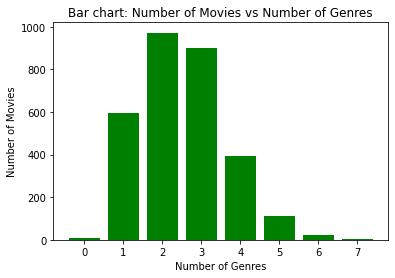

In [36]:
# your code goes here
import matplotlib.pyplot as plt

# genre counts freq
genre_counts_freq = train['genres'].apply(lambda val: len(val)).value_counts()

# Bar chart
plt.bar(genre_counts_freq.index, genre_counts_freq.values, color= 'g')
plt.xlabel('Number of Genres')
plt.ylabel('Number of Movies')
plt.title('Bar chart: Number of Movies vs Number of Genres')
plt.show()

Let's create our binary features next. Complete the following steps:
 
1.   Transform the `genres` column by replacing its current entries with the list of names of genres occurring in the entries.  For example, the entry 
```
[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]
```
should be transformed into:
```
['Romance','Comedy']
```
Empty entries should be transformed into the empty list `[]`.

2. Create a separate column (in `train`) for each of the 20 genres, with name `genres_(nameofgenre)` (e.g. `genres_Comedy`). A movie should have a 1 on a genres column if the genre is one of the associated genres for that movie, and a 0 otherwise.
    * To get started, consider what operations create a data frame with dimensions as `train` and columns as specified here, based on the list output from step 1. Then combine this data frame with `train`.

You have to use Pandas built-in functions only (no explicit looping).

In [37]:
# your code goes here

# Generalized func to one hot encode list features
def one_hot_encoding_list(feature):

    # Transfer feature column to list of names of feature occurring in the entries
    try:
        train[feature] = train[feature].apply(lambda lst: list(map(lambda dic: dic['name'], lst)))
    except:
        print(f'UserWarning:\n"{feature}" feature is already transferred.')
        return False

    # Number of most common classes to conseder within a feature  
    N = 20 if feature == 'genres' else 30
    
    # Most common classes to conseder within a feature 
    classes = train[feature].explode(feature).value_counts().index[0:N].tolist()
    
    # func to create a binary feature for each class 1 if exist 0 otherwise
    def insert_binary_col(nameofclass):
        train.insert(
                len(train.columns), 
                feature + '_' + nameofclass, 
                train[feature].apply(lambda lst: 1 if nameofclass in lst else 0)
                )
        return True

    # map insert_binary_col func on most common classes list
    list(map(insert_binary_col, classes))

    # Return True if everything is ok
    return True

# genres feature one hot encoding 
one_hot_encoding_list(feature='genres')

# Check
train.iloc[:,23:].head()

,genres_Drama,genres_Comedy,genres_Thriller,genres_Action,genres_Romance,genres_Crime,genres_Adventure,genres_Horror,genres_Science Fiction,genres_Family,genres_Fantasy,genres_Mystery,genres_Animation,genres_History,genres_War,genres_Music,genres_Documentary,genres_Western,genres_Foreign,genres_TV Movie
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Visualise the number of movies per top 20 genre with a chart of your choice.

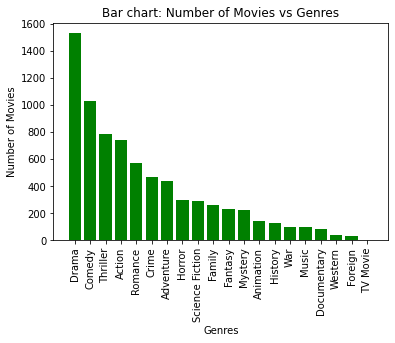

In [38]:
# your code goes here
# genre freq.
genre_freq = train['genres'].explode('genres').value_counts()

# Bar chart
plt.bar(genre_freq.index, genre_freq.values, color= 'g')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.title('Bar chart: Number of Movies vs Genres')
plt.xticks(rotation=90)
plt.show()

## Part 2: Adding more binary features (5 pts)

You've now extracted binary features for all genres associated with a movie. But there's other information that we could use to base our predictions on. 

The `genres` column is just one out of several columns containing lists of dictionaries as entries. For example, the `production_companies` column also contains lists of dictionaries, providing names of the companies producing the movie. As you just did with genres, add new columns for:
 
1.   The names of the 30 most common production companies
2.   The names of the 30 most common production countries
3.   The names of the 30 most common actors (`cast` column) 
4.   The names of the 30 most common crew members
5.   The names of the 30 most common keywords
 
We recommend you generalize the functionality implemented in the previous question (e.g. to other columns and to restrict to top 30 most common values).

In [39]:
# your code goes here

# selected features
features = ['production_companies', 'production_countries', 'Keywords', 'cast', 'crew']

# map the generalized function "one_hot_encoding_list(feature)" on the selected features list"
list(map(one_hot_encoding_list, features))

[True, True, True, True, True]

Check the result. You should now have a much wider table, with the new columns consisting of binary features.

In [40]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,genres_Drama,genres_Comedy,genres_Thriller,genres_Action,genres_Romance,genres_Crime,genres_Adventure,genres_Horror,genres_Science Fiction,genres_Family,genres_Fantasy,genres_Mystery,genres_Animation,genres_History,genres_War,genres_Music,genres_Documentary,...,cast_Michael Caine,cast_Robert Duvall,cast_Dennis Quaid,cast_Denzel Washington,cast_Ed Harris,cast_Richard Jenkins,cast_Matt Damon,cast_George Clooney,cast_Frank Welker,cast_Kevin Bacon,crew_Avy Kaufman,crew_Robert Rodriguez,crew_Deborah Aquila,crew_James Newton Howard,crew_Mary Vernieu,crew_Luc Besson,crew_Jerry Goldsmith,crew_Steven Spielberg,crew_Tricia Wood,crew_Francine Maisler,crew_James Horner,crew_Kerry Barden,crew_Janet Hirshenson,crew_Harvey Weinstein,crew_Bob Weinstein,crew_Jane Jenkins,crew_Francis Ford Coppola,crew_Hans Zimmer,crew_John Papsidera,crew_John Debney,crew_Mindy Marin,crew_Danny Elfman,crew_Billy Hopkins,crew_Tim Bevan,crew_Mark Isham,crew_Neal H. Moritz,crew_Hans Bjerno,crew_Sarah Finn,crew_Alan Silvestri,crew_Dan O'Connell
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,[Comedy],NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],2015-02-20,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...","[Kelly Cantley, Steve Pink, Josh Heald, Josh H...",12314651,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[Comedy, Drama, Family, Romance]",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],[United States of America],2004-08-06,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...","[Garry Marshall, Charles Minsky, John Debney, ...",95149435,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,{},3300000,[Drama],http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...","[Terri Taylor, Richard Henderson, Jeffrey Stot...",13092000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,{},1200000,"[Thriller, Drama]",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,[],[India],2012-03-09,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[mystery, bollywood, police corruption, crime,...","[Vidya Balan, Nawazuddin Siddiqui, Parambrata ...","[Sujoy Ghosh, Sujoy Ghosh, Sujoy Ghosh]",16000000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,{},0,"[Action, Thriller]",NaN,tt1380152,ko,마린보이,Marine Boy is 

 ## Part 3: Adding numerical date features (5 points)

Next, we'll create some features based on the release date information. Create a new column storing the value for each of the following  aspects of a release date:
 
```
['year', 'weekday', 'month', 'weekofyear', 'day', 'quarter']
```
 
As usual, don't iterate explicitly to create these columns.

In [41]:
# your code goes here
# Add 'day' feature
train['day'] = train['release_date'].dt.day

# Add 'month' feature 
train['month'] = train['release_date'].dt.month

# Add 'year' feature
train['year'] = train['release_date'].dt.year

# Add 'weekday' feature: with Monday=0, Sunday=6
train['weekday'] = train['release_date'].dt.dayofweek 

# Add 'weekofyear' feature 
train['weekofyear'] = train['release_date'].dt.weekofyear

# Add 'quarter' feature 
train['quarter'] = train['release_date'].dt.quarter

Next, we'll drop the columns that will not be used for learning. 

In [42]:
train = train.drop(['id', 'homepage', 'original_language',
                    'title', 'imdb_id','crew', 'poster_path', 
                    'release_date', 'status', 'belongs_to_collection',
                    'Keywords', 'original_title', 'overview',
                    'production_companies', 'production_countries', 
                    'spoken_languages', 'tagline', 'cast','genres'], 
                   axis=1)

Lastly, drop any rows with missing values.

In [43]:
# your code goes here
train = train.dropna()

## Part 4: Prediction (10 pts)

Let's load the necessary `sklearn` libraries and prepare the training data for learning. Recall that your goal is to predict whether a movie has science fiction as an associated genre. So you're dealing with a binary classification task.

In [44]:
from sklearn.model_selection import train_test_split

Use `sklearn` to prepare the training and test sets, setting aside 15% of the data for testing. Call the training input features, training labels, test input features and test labels as follows:

```
x_train, x_test, y_train, y_test
```



In [45]:
# your code goes here
# Split-out X,y datasets
X = train.loc[:, train.columns != 'genres_Science Fiction'].to_numpy()
y = train.loc[:,'genres_Science Fiction'].to_numpy()

# Set up seed and test size
seed = 174360
test_size = 0.15  

# Split-out train, test datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify = y)
print (f'{len(y_train)} samples to train.\n{len(y_test)} to test the final model on (unseen data).')

2548 samples to train.
450 to test the final model on (unseen data).


Feature scaling is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance). Run the following code to feature scale your input data.

In [46]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(x_train)  
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test)

Check that the shape of your data looks correct.

In [47]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2548, 179) (2548,)
(450, 179) (450,)


Train a classifier of your choice. Then report results:
* Display the confusion matrix over the test set in absolute numbers.
    * These numbers reflect number of true positives, true negatives, false positives and false negatives.
* Display a normalized confusion matrix over the test set, so [sensitivity and specificity](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers) can be read from the diagonal (off-diagonal will contain type I and type II error rates).
    * Note that sensitivity is recall for the positive class (1), whereas specificity is recall for the negative class (0).
* State **in free-text** the sensitivity and specificity of your classifier.

In [48]:
# your code goes here
# =============== Libraries
""" for models """
from sklearn.linear_model import LogisticRegression

""" for model selection cv """ 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

""" for Reporting metrics """
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score

""" printing """
def pprint(iter):
    if type(iter) == dict : 
        for item in iter.items(): print('\t', item)
    elif type(iter) == list:
        for item in iter: print('\t', item)
    else:
        try: print(iter)
        except: raise Exception


# =============== Tuning: Logistic Regression
""" scoring """
scoring = 'f1'

""" define model """
model = LogisticRegression()

""" define grid """
grid = dict()
grid['class_weight'] = ['balanced']      # Weights associated with classes in the form.
grid['solver'] = ['liblinear', 'saga']   # Algorithm to use in the optimization problem.
grid['penalty'] = ['l1', 'elasticnet']   # Regularization method; The norm used in the penalization
grid['C'] = [100, 10, 1.0, 0.1, 0.01]    # Inverse of regularization strength; must be a positive float. smaller values specify stronger regularization.

""" define model evaluation method """
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=seed)

""" define search """
search = GridSearchCV(estimator = model, param_grid = grid, scoring=scoring, cv=cv, n_jobs = -1, verbose = 2)

""" perform the search """
results = search.fit(x_train, y_train)

""" summarize """
print(f"Best {scoring} score: {np.round(results.best_score_,2)} ({np.round(results.cv_results_['std_test_score'][results.best_index_],2)})")
print("Using:") 
pprint(results.best_params_)

Fitting 9 folds for each of 20 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.4min finished


Best f1 score: 0.43 (0.01)
Using:
	 ('C', 0.1)
	 ('class_weight', 'balanced')
	 ('penalty', 'l1')
	 ('solver', 'saga')


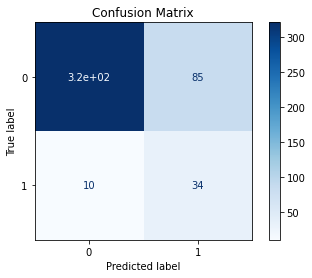

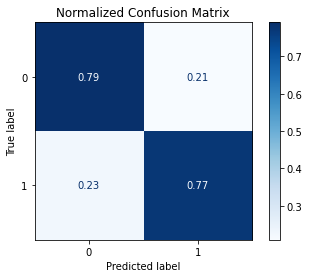

Sensitivity: 0.773
Specificity: 0.791


In [49]:
# =============== Final model:
""" define and fit final model """
model = LogisticRegression(**results.best_params_)
model.fit(x_train, y_train)

# =============== Report:
""" Confusion Matrix """
disp = plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues, normalize=None, include_values= True)  
disp.ax_.set_title('Confusion Matrix')
plt.grid(False)
plt.show()

""" Normalized Confusion Matrix """
disp = plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues, normalize='true', include_values= True)  
disp.ax_.set_title('Normalized Confusion Matrix')
plt.grid(False)
plt.show()

""" Sensitivity & Specificity """
predictions = model.predict(x_test)
print('Sensitivity: %.3f' % recall_score(y_test, predictions, average='binary', pos_label = 1))
print('Specificity: %.3f' % recall_score(y_test, predictions, average='binary', pos_label = 0))

*Your explanation here*

**Split data for Learning:**
- 85% cross-validation set (to train the model). 
- 15% test set (to validate the final model, unseen data).
- Stratified split since we want the two sets above to have the same labels distribution. 

**Evaluation Metric:**
- We chose the f1 score because it evenly weights precision and recall and is the most commonly used option when learning from unbalanced data like the one we have.

**Model Selection:**  
Because it provides a linear decision boundary, has a few assumptions, and is a solid baseline model for a binary classification task, we selected to tune a *logistic regression model*. We utilized *Cross-Validation* with stratified splits to determine the optimal parameter combinations (best model) because we want the training and test data of each CV fold to have the same labels distribution.

**Best Model:**  
Weighted logistic regression with L1-regularization(Lasso) was the best model. Which makes sense because: weighted inputs help deal with the problem of having unbalanced data, and L1-regularization aids feature selection by removing non-essential characteristics. When there are a lot of feature points, this is quite useful.



**Report results:**
The final model givis on the test (unseendata):
- *Sensitivity = 0.773*
- *Specificity = 0.791*  

which good a good tradoff between both Sensitivity and Specificity.  

## Part 5: Prediction with less leakage (5 points)

From Wikipedia, [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)) is the use of information in the model training process which would not be expected to be available at prediction time, causing the predictive scores (metrics) to overestimate the model's utility when run in a production environment.

Feature or column-wise leakage is caused by the inclusion of columns which are one of the following: a duplicate label, a proxy for the label, or the label itself

Considering we're doing binary classification of whether a movie is science fiction, identify the most prominent cause of feature leakage among the features added during Exercise 3. 

1) **Argue** for your choice, 2) train a classifier not subject to this feature leakage (it's OK to create a new train/test split) and 3) **report the results** as you did in Part 4.

*Your explanation here*

The most prominent cause of feature leakage among the features added during Exercise 3 are: 
- She added numerical features based on the release date information.
- Some of the extracted binary features for all crews associated with a movie.

The following pairs of features are verified, see code below, to be highly corrlated with (|cor.| > 0.75):
- month, weekofyear 
- month, quarter
- weekofyear, quarter
- crew_Janet Hirshenson, crew_Jane Jenkins
- crew_Bob Weinstein, crew_Harvey Weinstein
- crew_Deborah Aquila, crew_Tricia Wood
- production_companies_Working Title Films, crew_Tim Bevan

Each feature, from the aforementioned highly corrlated pair of features, seems to have a proxy wich introduce feature or column-wise leakage. 

To deal with feature or column-wise leakage, we can *delete some proxies* Like quarter, weekofyear and keep month. We can also keep one of the features from the other pair of features in the aforementioned list while deleting one. Moreover, using *L1-regularization* helps in feature selection by removing non-essential feature, this is quite useful.


**In the below implementation (code):**  
We take a similar strategy to the first implementation, except that we remove one feature from each highly correlated pair of features.

*Report results:*  
The final model givis on the test (unseendata):
- *Sensitivity = 0.773*
- *Specificity = 0.803*



Not so much improvment, The Specificity has increased slightly here, due to the fact that the final model in the first implementation, like this one, used *L1-regularization*, which aids in feature selection by removing non-essential features (for example, proxy), and this was also dealing with feature or column-wise leakage.


In [50]:
# your code goes here
# ===============  Correlation
""" set threshold """
threshold = 0.75

""" corr matrix """
corr_matrix = np.corrcoef(train.to_numpy(),rowvar=False)

""" mask corr. matrix magnitude > threshold """ 
mask = np.round(abs(corr_matrix),2) > threshold

""" diagonal not considered """
np.fill_diagonal(mask,False)

""" find indices high corr. features """
mask_true_indices = np.where(mask==True)
zipped = zip(mask_true_indices[0], mask_true_indices[1])
high_corr_indices = sorted(list(set(map(tuple,map(sorted,zipped)))))

def to_col_names(tup, features_names = train.columns):    
    return f'({features_names[tup[0]]}, {features_names[tup[1]]}) with corr = {np.round(corr_matrix[tup[0],tup[1]],2)}'

print(f'The following features has |Correlation| > {threshold}:')
pprint(list(map(to_col_names, high_corr_indices)))

The following features has |Correlation| > 0.75:
	 (production_companies_Working Title Films, crew_Tim Bevan) with corr = 0.79
	 (crew_Deborah Aquila, crew_Tricia Wood) with corr = 0.88
	 (crew_Janet Hirshenson, crew_Jane Jenkins) with corr = 0.95
	 (crew_Harvey Weinstein, crew_Bob Weinstein) with corr = 0.97
	 (month, weekofyear) with corr = 0.96
	 (month, quarter) with corr = 0.97
	 (weekofyear, quarter) with corr = 0.94


In [51]:
# =============== Datasets:
""" new dataset """
train_new = train.copy()
del(train_new['month'])
del(train_new['quarter'])
del(train_new['production_companies_Working Title Films'])
del(train_new['crew_Deborah Aquila'])
del(train_new['crew_Harvey Weinstein'])
del(train_new['crew_Janet Hirshenson'])

""" Split X,y """
X = train_new.loc[:, train_new.columns != 'genres_Science Fiction'].to_numpy()
y = train_new.loc[:,'genres_Science Fiction'].to_numpy()

""" Split train, test """
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify = y)


# =============== Tuning: Logistic Regression
""" scoring """
scoring = 'f1'

""" define model """
model = LogisticRegression()

""" define grid """
grid = dict()
grid['class_weight'] = ['balanced']      # Weights associated with classes in the form.
grid['solver'] = ['liblinear', 'saga']   # Algorithm to use in the optimization problem.
grid['penalty'] = ['l1', 'elasticnet']   # Regularization method; The norm used in the penalization
grid['C'] = [100, 10, 1.0, 0.1, 0.01]    # Inverse of regularization strength; must be a positive float. smaller values specify stronger regularization.

""" define model evaluation method """
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=seed)

""" define search """
search = GridSearchCV(estimator = model, param_grid = grid, scoring=scoring, cv=cv, n_jobs = -1, verbose = 2)

""" perform the search """
results = search.fit(x_train, y_train)

""" summarize """
print(f"Best {scoring} score: {np.round(results.best_score_,2)} ({np.round(results.cv_results_['std_test_score'][results.best_index_],2)})")
print("Using:") 
pprint(results.best_params_)

Fitting 9 folds for each of 20 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   57.7s finished


Best f1 score: 0.44 (0.02)
Using:
	 ('C', 1.0)
	 ('class_weight', 'balanced')
	 ('penalty', 'l1')
	 ('solver', 'liblinear')


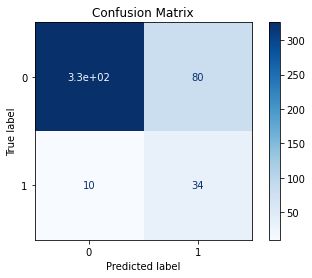

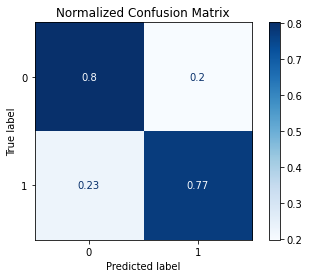

Sensitivity: 0.773
Specificity: 0.803


In [52]:
# =============== Final model:
""" define and fit final model """
model = LogisticRegression(**results.best_params_)
model.fit(x_train, y_train)

# =============== Report:
""" Confusion Matrix """
disp = plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues, normalize=None, include_values= True)  
disp.ax_.set_title('Confusion Matrix')
plt.grid(False)
plt.show()

""" Normalized Confusion Matrix """
disp = plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues, normalize='true', include_values= True)  
disp.ax_.set_title('Normalized Confusion Matrix')
plt.grid(False)
plt.show()

""" Sensitivity & Specificity """
predictions = model.predict(x_test)
print('Sensitivity: %.3f' % recall_score(y_test, predictions, average='binary', pos_label = 1))
print('Specificity: %.3f' % recall_score(y_test, predictions, average='binary', pos_label = 0))

# Exercise 4: Basic movie recommendation system (20 points)

In this exercise, you'll build a simple movie recommendation system.  The system will take a movie as input and recommend a list of similar movies. In order to recommend similar movies, you will use the correlation between the ratings of movies as a similarity metric. We'll use Pearson's correlation. 
 
The data for this exercise is available in the following URLs. It contains basic info about movies, as well as ratings provided by several users.

In [53]:
url1 = 'http://courses.compute.dtu.dk/02807/2021/projects/project1/ratings.csv'
url2 = 'http://courses.compute.dtu.dk/02807/2021/projects/project1/movies.csv'

## Part 1: Preparing the ratings data (10 pts)

Read the data from these two URLs, and create a single dataframe from them, with the following columns:

| userId | movieId | rating | timestamp | title | genres |
|--------|---------|--------|-----------|-------|--------|
|        |         |        |           |       |        |

Call the dataframe `movie_data`.

In [54]:
# your code goes here
""" load datasets """
ratings = pd.read_csv(url1)
movies  = pd.read_csv(url2)
movie_data = pd.merge(ratings, movies, how = 'inner', on = 'movieId')
display(movie_data.head())

""" free memory """
del(ratings, movies)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


To find the correlation between the ratings of movies, create a dataframe where each column is a movie name and each row contains the rating assigned by a specific user to that movie. 

You'll notice that this dataframe has many NaN values, since each movie is not rated by every user. Call the dataframe `user_ratings`.

In [55]:
# your code goes here
""" define user_ratings """
user_ratings = movie_data[['userId', 'rating', 'title']].pivot_table(index='userId', columns='title', values='rating')
display(user_ratings.head())

""" free memory """
del(movie_data)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Part 2: Finding the most similar movies (10 pts)

Each column contains all the user ratings for a particular movie. Let's take the user ratings for the movie Toy Story.

In [56]:
user_ratings['Toy Story (1995)'].head()

userId
1    4.0
2    NaN
3    NaN
4    NaN
5    4.0
Name: Toy Story (1995), dtype: float64

Next, find the correlation between the user ratings for Toy Story and the user ratings of all other movies. 
 
More specifically, create a dataframe that contains two columns, called `title` and `Correlation`. Each row should contain a movie title $x$, followed by the pairwise correlation between the column of ratings for Toy Story and the column of ratings for $x$.  Drop any rows with null values, and display the resulting dataframe.
 
Use built-in functions to compute correlations and avoid explicit loops.

In [57]:
# your code goes here
correlation_table = user_ratings.loc[:, user_ratings.columns != 'Toy Story (1995)'].corrwith(user_ratings['Toy Story (1995)'], method="pearson").dropna()
correlation_table = pd.DataFrame({'title': correlation_table.index, 'Correlation': correlation_table.values})
correlation_table.head()

,title,Correlation
0,"'burbs, The (1989)",0.240563
1,(500) Days of Summer (2009),0.353833
2,*batteries not included (1987),-0.427425
3,10 Cent Pistol (2015),1.000000
4,10 Cloverfield Lane (2016),-0.285732


Sort the movies by descending order of correlation to find out highly correlated movies at the top. Display the 5 most highly correlated movies.


In [58]:
# your code goes here
correlation_table = correlation_table.sort_values(by='Correlation', ascending=False)
correlation_table.head()

,title,Correlation
2383,Land Before Time III: The Time of the Great Gi...,1.0
1522,For the Birds (2000),1.0
1454,"Final Destination, The (Final Destination 4) (...",1.0
876,Coffee Town (2013),1.0
3297,Police Story 2 (Ging chaat goo si juk jaap) (1...,1.0


If you computed correlations correctly, you will find that the recommended movies are not very well known. We can generate more popular recommendations by finding highly correlated movies that have a sensible number of ratings. 
 
Add a column to your correlation table, called `rating_counts`, which stores the number of ratings received by each movie.

In [59]:
# your code goes here
""" define rating counts data """
rating_counts_data = user_ratings.notnull().sum(axis=0)
rating_counts_data = pd.DataFrame({'title':rating_counts_data.index, 'rating_counts':rating_counts_data.values})

""" merge """
correlation_table = pd.merge(correlation_table, rating_counts_data, how = 'inner', on = 'title')
display(correlation_table.head())

""" free memory """
del(rating_counts_data, user_ratings)

,title,Correlation,rating_counts
0,Land Before Time III: The Time of the Great Gi...,1.0,3
1,For the Birds (2000),1.0,5
2,"Final Destination, The (Final Destination 4) (...",1.0,3
3,Coffee Town (2013),1.0,2
4,Police Story 2 (Ging chaat goo si juk jaap) (1...,1.0,2


Now find the 5 movies with the highest correlation with Toy Story, which have strictly more than 100 ratings. Display the result below. 

In [60]:
# your code goes here
correlation_table[correlation_table['rating_counts'] > 100].sort_values(by='Correlation', ascending=False).head(5)

,title,Correlation,rating_counts
1060,"Incredibles, The (2004)",0.643301,125
1107,Finding Nemo (2003),0.618701,141
1127,Aladdin (1992),0.611892,183
1465,"Monsters, Inc. (2001)",0.490231,132
1582,Mrs. Doubtfire (1993),0.446261,144
